# CPU vs GPU Performance Analysis

This notebook analyzes the performance of CPU vs GPU training across different
batch sizes and data sizes (num_sessions), comparing:
- **elapsed_seconds**: Processing time only (training time)
- **wandb_runtime**: Total time including overhead (memory loading, initialization)

In [42]:
# Autoload notebook extension for improved usability
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Initialize Client and Fetch Data

In [43]:
from aind_disrnn_result_access import WandbClient
import pandas as pd

client = WandbClient()

In [44]:
# Get runs from han_cpu_gpu_test project
df = client.get_runs_dataframe(
    project="han_cpu_gpu_test",
    per_page=100
)

print(f"Total runs: {len(df)}")
df.head()

Total runs: 73


,id,name,state,created_at,url,tags,config.data.seed,config.data.task.mean,config.data.task.seed,config.data.task.type,...,config.data.subject_ids,config.data.multisubject,config.data.ignore_policy,summary.fig/update_rule_4._type,summary.fig/update_rule_4.format,summary.fig/update_rule_4.height,summary.fig/update_rule_4.path,summary.fig/update_rule_4.sha256,summary.fig/update_rule_4.size,summary.fig/update_rule_4.width
0,0q45cmry,1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0...,finished,2026-02-06T22:20:05Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lzij3ybo,1gpu4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0....,finished,2026-02-06T22:20:04Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0ec4vqq6,1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0...,finished,2026-02-06T22:20:04Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cju5e411,1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0...,finished,2026-02-06T22:20:03Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1mqgpxrq,1gpu4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0....,finished,2026-02-06T22:20:03Z,https://wandb.ai/AIND-disRNN/han_cpu_gpu_test/...,"batch_size,cpu,disrnn,synthetic",0,0.0,0.0,random_walk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Filter Runs by num_sessions

In [45]:
# Filter for num_sessions in (100, 1000, 10000)
filtered_df = df[
    df['config.data.num_sessions'].isin([100, 1000, 10000])
]

print(f"Filtered runs: {len(filtered_df)}")
print(f"\nnum_sessions distribution:")
print(filtered_df['config.data.num_sessions'].value_counts().sort_index())

Filtered runs: 30

num_sessions distribution:
config.data.num_sessions
100.0      10
1000.0     10
10000.0    10
Name: count, dtype: int64


## 3. Identify CPU vs GPU from Run Name

In [46]:
# Check run name patterns
print("Sample run names:")
for name in filtered_df['name'].head(10):
    print(f"  {name}")

# Identify device type from run name
# Names with 'gpu' indicate GPU runs, others are CPU-only
filtered_df = filtered_df.copy()
filtered_df['device'] = filtered_df['name'].apply(
    lambda x: 'GPU' if 'gpu' in x.lower() else 'CPU'
)

print(f"\nDevice distribution:")
print(filtered_df['device'].value_counts())

Sample run names:
  1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1
  1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_grad_clip1

Device distribution:
device
GPU    15
CPU    15
Name: count, dtype: int64


## 4. Extract Batch Size (patch_size)

In [47]:
# Get batch_size (used as patch_size for this analysis)
batch_sizes = filtered_df['config.data.batch_size'].unique()
print(f"Unique batch sizes: {sorted(batch_sizes)}")

Unique batch sizes: [np.float64(128.0), np.float64(256.0), np.float64(512.0), np.float64(1024.0), np.float64(2048.0)]


## 5. Prepare Data for Plotting

In [48]:
# Select relevant columns
plot_df = filtered_df[[
    'name',
    'config.data.num_sessions',
    'config.data.batch_size',
    'summary.elapsed_seconds',
    'summary._wandb.runtime',
    'device'
]].copy()

# Rename for clarity
plot_df = plot_df.rename(columns={
    'config.data.num_sessions': 'num_sessions',
    'config.data.batch_size': 'batch_size',
    'summary.elapsed_seconds': 'elapsed_seconds',
    'summary._wandb.runtime': 'wandb_runtime'
})

# Sort by num_sessions and batch_size
plot_df = plot_df.sort_values(['num_sessions', 'batch_size'])

# Calculate overhead (difference between total runtime and processing time)
plot_df['overhead_seconds'] = plot_df['wandb_runtime'] - plot_df['elapsed_seconds']
plot_df['overhead_pct'] = (plot_df['overhead_seconds'] / plot_df['wandb_runtime'] * 100).round(1)

print(plot_df[['name', 'num_sessions', 'batch_size', 'elapsed_seconds', 'wandb_runtime', 'overhead_seconds', 'overhead_pct']].head(10))

                                                 name  num_sessions  \
10  1gpu4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0....         100.0   
29  4cpu64G_bs128_wu500_5_3_4_0_beta0.001_lr0.005_...         100.0   
14  1gpu4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0....         100.0   
26  4cpu64G_bs256_wu500_5_3_4_0_beta0.001_lr0.005_...         100.0   
7   1gpu4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0....         100.0   
17  4cpu64G_bs512_wu500_5_3_4_0_beta0.001_lr0.005_...         100.0   
5   1gpu4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0...         100.0   
22  4cpu64G_bs1024_wu500_5_3_4_0_beta0.001_lr0.005...         100.0   
8   1gpu4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0...         100.0   
18  4cpu64G_bs2048_wu500_5_3_4_0_beta0.001_lr0.005...         100.0   

    batch_size  elapsed_seconds  wandb_runtime  overhead_seconds  overhead_pct  
10       128.0      1780.984864         1979.0        198.015136          10.0  
29       128.0      2826.016939         2974.0        14

## 6. Create Plot: Time vs num_sessions (with and without overhead)

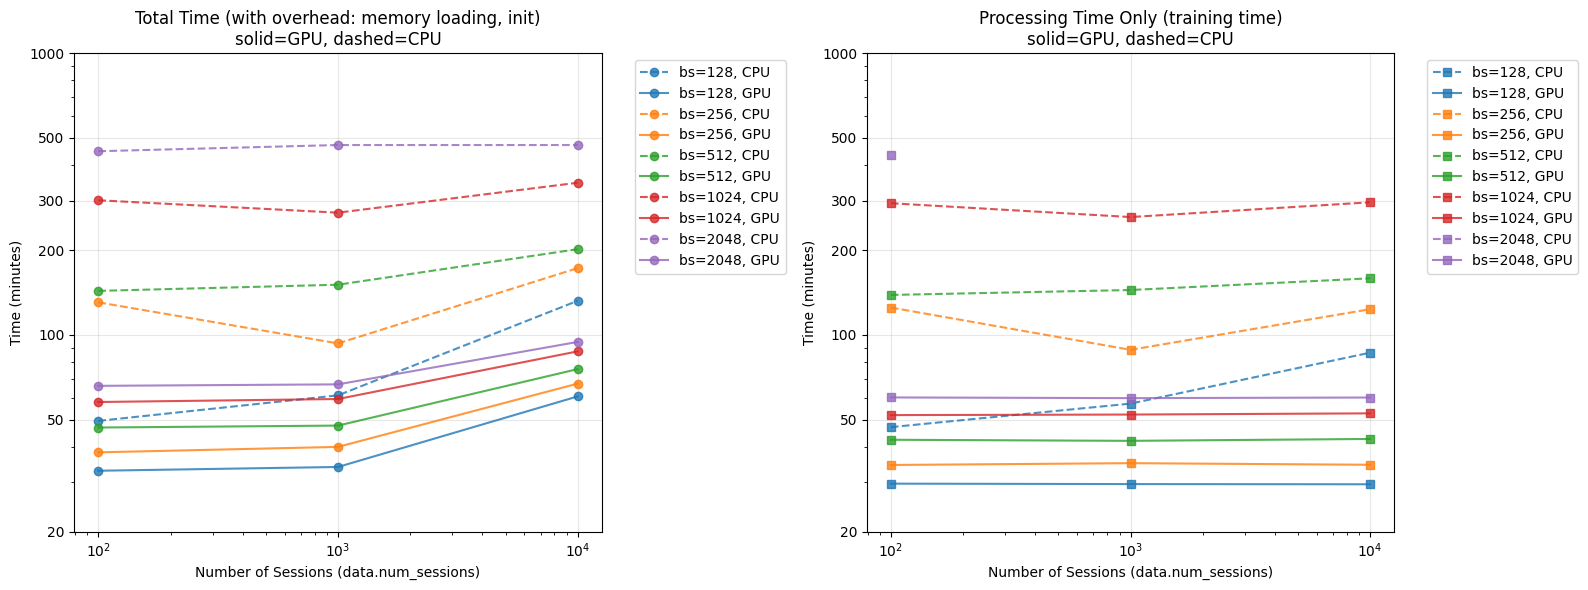

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Set up the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get unique batch sizes and devices
batch_sizes = sorted(plot_df['batch_size'].unique())
devices = ['CPU', 'GPU']  # CPU first (plotted on top), GPU last (at bottom)

# Define colors for each batch size
colors = plt.cm.tab10(range(len(batch_sizes)))

# Define explicit y-axis ticks (in minutes)
yticks = [20, 50, 100, 200, 300, 500, 1000]

# --- Left plot: With overhead (wandb_runtime) ---
for i, bs in enumerate(batch_sizes):
    for device in devices:
        data = plot_df[
            (plot_df['batch_size'] == bs) &
            (plot_df['device'] == device)
        ].sort_values('num_sessions')
        
        if len(data) > 0 and data['wandb_runtime'].notna().any():
            linestyle = '-' if device == 'GPU' else '--'
            label = f'bs={int(bs)}, {device}'
            
            ax1.plot(
                data['num_sessions'],
                data['wandb_runtime'] / 60,  # Convert to minutes
                marker='o',
                linestyle=linestyle,
                color=colors[i],
                label=label,
                alpha=0.8
            )

ax1.set_xlabel('Number of Sessions (data.num_sessions)')
ax1.set_ylabel('Time (minutes)')
ax1.set_title('Total Time (with overhead: memory loading, init)\nsolid=GPU, dashed=CPU')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_yticks(yticks)
ax1.get_yaxis().set_major_formatter(ScalarFormatter())

# --- Right plot: Without overhead (elapsed_seconds only) ---
for i, bs in enumerate(batch_sizes):
    for device in devices:
        data = plot_df[
            (plot_df['batch_size'] == bs) &
            (plot_df['device'] == device)
        ].sort_values('num_sessions')
        
        if len(data) > 0 and data['elapsed_seconds'].notna().any():
            linestyle = '-' if device == 'GPU' else '--'
            label = f'bs={int(bs)}, {device}'
            
            ax2.plot(
                data['num_sessions'],
                data['elapsed_seconds'] / 60,  # Convert to minutes
                marker='s',
                linestyle=linestyle,
                color=colors[i],
                label=label,
                alpha=0.8
            )

ax2.set_xlabel('Number of Sessions (data.num_sessions)')
ax2.set_ylabel('Time (minutes)')
ax2.set_title('Processing Time Only (training time)\nsolid=GPU, dashed=CPU')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_yticks(yticks)
ax2.get_yaxis().set_major_formatter(ScalarFormatter())

plt.tight_layout()
plt.show()

## 7. Overhead Analysis

In [50]:
# Group by device and num_sessions to see average overhead
overhead_summary = plot_df.groupby(
    ['device', 'num_sessions']
)[['elapsed_seconds', 'wandb_runtime', 'overhead_seconds', 'overhead_pct']].mean()

print("Average time metrics by device and num_sessions:")
print(overhead_summary)

Average time metrics by device and num_sessions:
                     elapsed_seconds  wandb_runtime  overhead_seconds  \
device num_sessions                                                     
CPU    100.0            12465.077265        12873.0        407.922735   
       1000.0            8281.743795        12586.2        370.506205   
       10000.0           9968.308154        15903.6       2830.441846   
GPU    100.0             2624.844902         2905.2        280.355098   
       1000.0            2624.064201         2974.4        350.335799   
       10000.0           2635.676425         4624.4       1988.723575   

                     overhead_pct  
device num_sessions                
CPU    100.0                3.600  
       1000.0               4.825  
       10000.0             24.750  
GPU    100.0                9.680  
       1000.0              11.940  
       10000.0             43.880  


## 8. Summary Statistics (Processing Time Only)

In [51]:
# Group by device, num_sessions, and batch_size
summary = plot_df.groupby(
    ['device', 'num_sessions', 'batch_size']
)['elapsed_seconds'].mean().unstack(fill_value=None)

print("Average elapsed time (seconds) by configuration:")
print(summary)

Average elapsed time (seconds) by configuration:
batch_size                128.0        256.0        512.0         1024.0  \
device num_sessions                                                        
CPU    100.0         2826.016939  7508.249438  8322.186712  17602.748805   
       1000.0        3424.512534  5314.422302  8663.038978  15725.001368   
       10000.0       5193.735566  7406.410477  9533.353957  17739.732616   
GPU    100.0         1780.984864  2074.458825  2548.951652   3117.877574   
       1000.0        1774.693663  2105.340669  2526.675028   3132.028254   
       10000.0       1771.868139  2078.005200  2565.899305   3162.818835   

batch_size                 2048.0  
device num_sessions                
CPU    100.0         26066.184430  
       1000.0                 NaN  
       10000.0                NaN  
GPU    100.0          3601.951596  
       1000.0         3581.583392  
       10000.0        3599.790649  
